In [322]:
import torch
import numpy as np
import pandas as pd
import cv2
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from pathlib import Path

from transforms import (DualCompose,
                        ImageOnly,
                        Normalize,
                        HorizontalFlip,
                        VerticalFlip)

PATH = Path('data/carvana')
MASKS_FN = 'train_masks.csv'
META_FN = 'metadata.csv'
masks_csv = pd.read_csv(PATH/MASKS_FN)
meta_csv = pd.read_csv(PATH/META_FN)
TRAIN_DN = 'train-128'
MASKS_DN = 'train_masks-128'

%matplotlib inline
from pylab import *

In [29]:
list(PATH.iterdir())

[PosixPath('data/carvana/train.zip'),
 PosixPath('data/carvana/sample_submission.csv'),
 PosixPath('data/carvana/train_masks.csv'),
 PosixPath('data/carvana/train_masks_png'),
 PosixPath('data/carvana/train_masks-128'),
 PosixPath('data/carvana/test'),
 PosixPath('data/carvana/train_masks.csv.zip'),
 PosixPath('data/carvana/metadata.csv'),
 PosixPath('data/carvana/train_hq'),
 PosixPath('data/carvana/sample_submission.csv.zip'),
 PosixPath('data/carvana/train-128'),
 PosixPath('data/carvana/train_hq.zip'),
 PosixPath('data/carvana/train_masks-512'),
 PosixPath('data/carvana/train-1024'),
 PosixPath('data/carvana/test_hq.zip'),
 PosixPath('data/carvana/train_masks.zip'),
 PosixPath('data/carvana/models'),
 PosixPath('data/carvana/train_masks'),
 PosixPath('data/carvana/test_hq'),
 PosixPath('data/carvana/train'),
 PosixPath('data/carvana/metadata.csv.zip'),
 PosixPath('data/carvana/train-512'),
 PosixPath('data/carvana/train_masks-1024'),
 PosixPath('data/carvana/tmp'),
 PosixPath('data

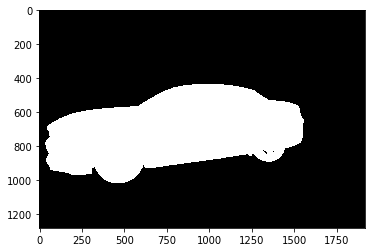

In [25]:
imshow(cv2.imread(str(next((data_path/'train_masks_png').iterdir()))))

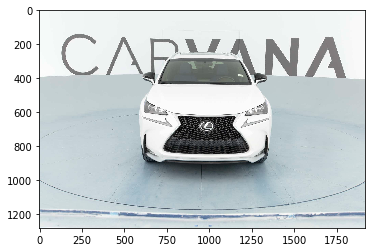

In [19]:
imshow(cv2.imread(str(next((data_path/'train').iterdir()))))

In [370]:
class CarvanaDataset(Dataset):
    def __init__(self, file_names: list, to_augment=False, transform=None, mode='train', problem_type=None):
        self.file_names = file_names
        self.to_augment = to_augment
        self.transform = transform
        self.mode = mode

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        img_file_name = Path(self.file_names[idx])
        img = load_image(img_file_name)
        mask = load_mask(img_file_name)

#         img, mask = self.transform(img, mask)

        if self.mode == 'train':
            return to_float_tensor(img), to_float_tensor(mask)
        else:
            return to_float_tensor(img), str(img_file_name)


def to_float_tensor(img):
    return torch.from_numpy(np.moveaxis(img, -1, 0)).float()


def load_image(path):
    img = cv2.imread(str(path))
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


def load_mask(path):
    mask_path = Path(PATH, path.parts[-2].replace('-', '_masks-'), path.stem + '_mask.png')
    return cv2.imread(str(mask_path))[:,:,:1]

In [371]:
def make_loader(file_names, shuffle=False, transform=None, workers=4):
    return DataLoader(
        dataset=CarvanaDataset(file_names, transform=transform),
        shuffle=shuffle,
        num_workers=workers,
        batch_size=64,
        pin_memory=torch.cuda.is_available()
    )

In [372]:
np.random.seed = 42

In [373]:
file_names = [PATH/TRAIN_DN/o for o in masks_csv['img']]
ids = np.array(list(set([f[:-7] for f in masks_csv['img']])))
val_ids = np.random.choice(ids, 64, False)
val_file_names = np.array([f for f in file_names if f.stem[:-3] in val_ids])
train_file_names = np.array([f for f in file_names if f.stem[:-3] not in val_ids])

In [374]:
train_transform = DualCompose([
    HorizontalFlip(),
    VerticalFlip(),
    ImageOnly(Normalize())
])

val_transform = DualCompose([
    ImageOnly(Normalize())
])

In [375]:
train_loader = make_loader(train_file_names, shuffle=True, transform=train_transform)
valid_loader = make_loader(val_file_names, transform=val_transform)

In [376]:
tester = next(iter(train_loader))

In [377]:
tester[1].shape

torch.Size([64, 1, 128, 128])

In [333]:
!wget https://github.com/ternaus/robot-surgery-segmentation/raw/master/loss.py

--2018-04-03 00:53:06--  https://github.com/ternaus/robot-surgery-segmentation/raw/master/loss.py
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ternaus/robot-surgery-segmentation/master/loss.py [following]
--2018-04-03 00:53:06--  https://raw.githubusercontent.com/ternaus/robot-surgery-segmentation/master/loss.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.200.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.200.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2091 (2.0K) [text/plain]
Saving to: ‘loss.py’

loss.py             100%[===================>]   2.04K  --.-KB/s    in 0s      

2018-04-03 00:53:06 (47.1 MB/s) - ‘loss.py’ saved [2091/2091]

